##### Importing libraries

In [2]:
import tensorflow as tf
tf.config.set_visible_devices([], "GPU")

2025-04-15 11:34:53.719084: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import os
import glob as glob
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import cv2
from tqdm import tqdm
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import PIL.Image as Image
from PIL import ImageOps

from skimage.io import imread, imshow
from skimage.transform import resize
from IPython.display import Image, display

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

from keras import layers, models, callbacks
from keras.models import Sequential, Model
from keras.utils import load_img, normalize
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, AveragePooling2D
from keras.layers import Concatenate, concatenate, BatchNormalization, Dropout, Lambda, Activation
from keras.applications import ResNet50
from keras.models import Model
from keras import backend as K

##### EXTRA: GPU Memory Upgrade

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)

##### EXTRA: GPU Part of Code

In [2]:
print(tf.__version__)
tf.test.is_gpu_available()

2.10.1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

##### EXTRA: Clearing GPU Memory

In [19]:
import gc
tf.keras.backend.clear_session()
gc.collect()

105

##### EXTRA: Disable GPU

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU

##### Image loading, processing and modification based on requirements

In [6]:
SAMPLE_SIZE = (256, 256)
OUTPUT_SIZE = (650, 1250)

##### Loading images and masks, normalization and creation of binary segmentation masks

In [8]:
def load_images(image_path, label_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, OUTPUT_SIZE)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image / 255.0
    
    label = tf.io.read_file(label_path)
    label = tf.io.decode_png(label)
    label = tf.image.resize(label, OUTPUT_SIZE)
    label = tf.image.convert_image_dtype(label, tf.float32)
    label = label / 255.0
    
    cyan = tf.constant([0.0, 1.0, 1.0], dtype=tf.float32)
    mask_cyan = tf.reduce_all(tf.equal(label, cyan), axis=-1)
    label = tf.where(mask_cyan, 1.0, 0.0)
    label = tf.cast(label, tf.float32)
    
    image = tf.image.resize(image, SAMPLE_SIZE)
    label = tf.image.resize(label[..., tf.newaxis], SAMPLE_SIZE)

    return image, label

##### Creation of a combined dataset consisting of both the images for joint augmentation as seen later

In [11]:
def create_dataset(path_to_dir):
    images_path = sorted(glob.glob(f'{path_to_dir}/images/*.jpg'))
    labels_path = sorted(glob.glob(f'{path_to_dir}/labels/*.png'))

    images_dataset = tf.data.Dataset.from_tensor_slices(images_path)
    labels_dataset = tf.data.Dataset.from_tensor_slices(labels_path)

    dataset = tf.data.Dataset.zip((images_dataset, labels_dataset))
    dataset = dataset.map(load_images, num_parallel_calls=tf.data.AUTOTUNE)
    
    return dataset

#### Data Augmentation

##### Augmentation of the dataset

In [15]:
def augment_dataset(dataset, augment_size):
    new_dataset = dataset
    for _ in range(augment_size):
        augmented_dataset = [dataset.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)]
        new_dataset = new_dataset.concatenate(*augmented_dataset)
    new_dataset = new_dataset.shuffle(1000*augment_size)
    return new_dataset

##### Individual image augmentation tasks

In [18]:
def augment_data(image, mask):
    seed_one = np.random.randint(1, 100)
    seed_two = np.random.randint(1, 100)
    seed_three = np.random.randint(1, 4)
    
    image = tf.image.random_flip_left_right(image, seed=seed_one)
    mask = tf.image.random_flip_left_right(mask, seed=seed_one)
    
    image = tf.image.random_flip_up_down(image, seed=seed_two)
    mask = tf.image.random_flip_up_down(mask, seed=seed_two)
    
    image = tf.image.rot90(image, k=seed_three)
    mask = tf.image.rot90(mask, k=seed_three)
    
    return image, mask

##### Loading of the images, augmentation of the datasets and creating a train/test split of 70:30, 4 times augmentation

In [8]:
os.getcwd()

'C:\\Users\\Daniel\\OneDrive\\Desktop\\Oil Spill Detection Using Computer Vision'

In [21]:
os.getcwd()

'/Users/sibikarthik/OIL_SPILL_DETECTION/1) SAR U-Net (With Augmentation)'

In [23]:
dataset_p1 = create_dataset("/Users/sibikarthik/OIL_SPILL_DETECTION/SAR Data/train")
dataset_p2 = create_dataset("/Users/sibikarthik/OIL_SPILL_DETECTION/SAR Data/test")

dataset = dataset_p1.concatenate(dataset_p2)
dataset = augment_dataset(dataset, 1)

dataset_train, dataset_test = tf.keras.utils.split_dataset(dataset, left_size=0.7)
dataset_train = augment_dataset(dataset_train, 4)

2025-04-08 00:04:33.349387: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-04-08 00:04:33.349439: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-08 00:04:33.349453: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-08 00:04:33.350325: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-08 00:04:33.351131: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-04-08 00:04:33.767577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore thi

##### Metadata of number of images

In [25]:
print(len(list(dataset_train)))
print(len(list(dataset_test)))

2025-04-08 00:05:07.428848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [1557,256,256,1]
	 [[{{node Placeholder/_1}}]]
2025-04-08 00:05:07.515824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype float and shape [1557,256,256,3]
	 [[{{node Placeholder/_5}}]]


7785
667


2025-04-08 00:05:21.763874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [667,256,256,1]
	 [[{{node Placeholder/_1}}]]


##### Sample printing of dataset

2025-04-08 00:05:33.724812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_21' with dtype float and shape [1557,256,256,3]
	 [[{{node Placeholder/_21}}]]
2025-04-08 00:05:33.755360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype float and shape [1557,256,256,3]
	 [[{{node Placeholder/_13}}]]


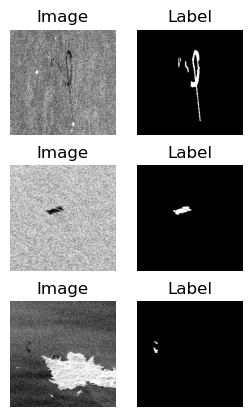

In [27]:
num_samples = 3
sample = list(dataset_train.take(num_samples))
fig, ax = plt.subplots(nrows=num_samples, ncols=2, figsize=(3, 5))
for i, (image, label) in enumerate(sample):
    ax[i, 0].set_title('Image')
    ax[i, 0].set_axis_off()
    ax[i, 0].imshow(image)
    ax[i, 1].set_title('Label')
    ax[i, 1].set_axis_off()
    ax[i, 1].imshow(label, cmap='gray')

plt.show()
plt.close()

##### Dice loss and BCE (binary cross entropy)

In [10]:
def dice_mc_metric(a, b):
    a = tf.unstack(a, axis=3)
    b = tf.unstack(b, axis=3)
    dice_summ = 0
    
    for i, (aa, bb) in enumerate(zip(a, b)):
        numenator = 2 * tf.math.reduce_sum(aa * bb) + 1
        denomerator = tf.math.reduce_sum(aa + bb) + 1
        dice_summ += numenator / denomerator
    return dice_summ / 2
    
def dice_mc_loss(a, b):
    return 1 - dice_mc_metric(a, b)

def dice_bce_mc_loss(a, b):
    return 0.3 * dice_mc_loss(a, b) + tf.reduce_mean(tf.keras.losses.binary_crossentropy(a, b))

#### U-Net Architecture

In [31]:
def input_layer():
    return tf.keras.layers.Input(shape=SAMPLE_SIZE + (3,))

def downsample_block(filters, size, batch_norm=True):
    initializer = tf.keras.initializers.GlorotNormal()
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    
    if batch_norm:
        result.add(tf.keras.layers.BatchNormalization())
    
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample_block(filters, size, dropout=False):
    initializer = tf.keras.initializers.GlorotNormal()
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    
    if dropout:
        result.add(tf.keras.layers.Dropout(0.25))
    
    result.add(tf.keras.layers.ReLU())
    return result

def output_layer(size):
    initializer = tf.keras.initializers.GlorotNormal()
    return tf.keras.layers.Conv2DTranspose(1, size, strides=2, padding='same', kernel_initializer=initializer, activation='sigmoid')

In [32]:
import pydot
import graphviz
from tensorflow.keras.utils import plot_model

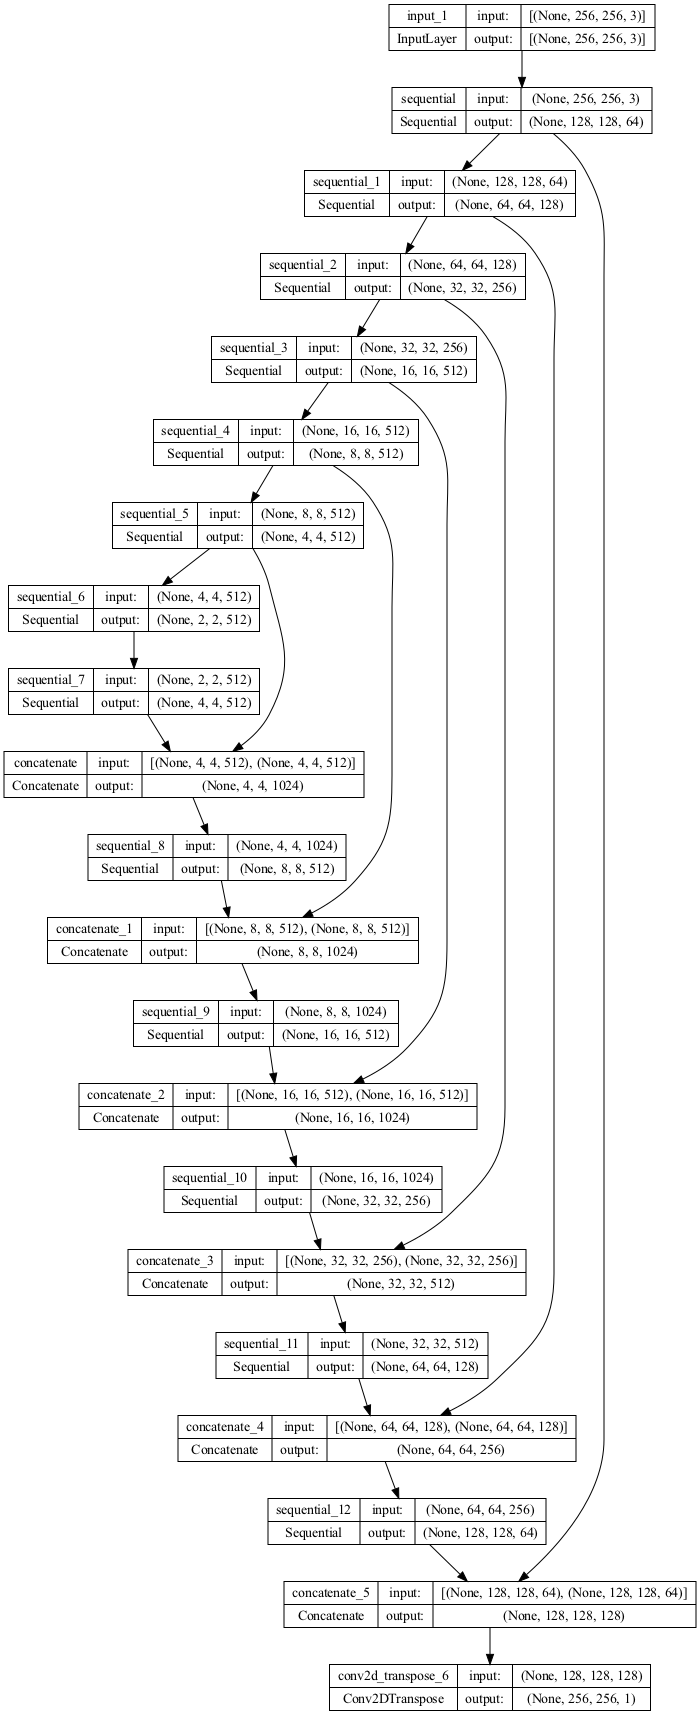

In [33]:
inp_layer = input_layer()

downsample_stack = [
    downsample_block(64, 4, batch_norm=False),
    downsample_block(128, 4),
    downsample_block(256, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
]

upsample_stack = [
    upsample_block(512, 4, dropout=True),
    upsample_block(512, 4, dropout=True),
    upsample_block(512, 4, dropout=True),
    upsample_block(256, 4),
    upsample_block(128, 4),
    upsample_block(64, 4)
]

out_layer = output_layer(4)
x = inp_layer
downsample_skips = []

for block in downsample_stack:
    x = block(x)
    downsample_skips.append(x)
downsample_skips = reversed(downsample_skips[:-1])

for up_block, down_block in zip(upsample_stack, downsample_skips):
    x = up_block(x)
    x = tf.keras.layers.Concatenate()([x, down_block])
out_layer = out_layer(x)

unet_model = tf.keras.Model(inputs=inp_layer, outputs=out_layer)
tf.keras.utils.plot_model(unet_model, show_shapes=True, dpi=72)

#### Running Model

In [16]:
unet_model.compile(optimizer='adam', loss=dice_bce_mc_loss, metrics=[dice_mc_metric, 'accuracy'])

In [42]:
batch_size = 8
dataset_train_batched = dataset_train.batch(batch_size)
dataset_test_batched = dataset_test.batch(batch_size)

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define checkpoint
checkpoint_path = "best_model_with_aug.keras"
checkpoint_callback = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor="val_loss", mode="min")

# Training model with checkpoint
unet = unet_model.fit(
    dataset_train_batched,
    validation_data=dataset_test_batched,
    epochs=25,
    callbacks=[checkpoint_callback]
)

Epoch 1/25
974/974 [==============================] - 117s 105ms/step - loss: 0.3235 - dice_mc_metric: 0.0953 - accuracy: 0.9875 - val_loss: 0.3049 - val_dice_mc_metric: 0.1223 - val_accuracy: 0.9900
Epoch 2/25
974/974 [==============================] - 106s 105ms/step - loss: 0.3003 - dice_mc_metric: 0.1494 - accuracy: 0.9886 - val_loss: 0.4220 - val_dice_mc_metric: 0.0012 - val_accuracy: 0.9890
Epoch 3/25
974/974 [==============================] - 109s 107ms/step - loss: 0.2930 - dice_mc_metric: 0.1676 - accuracy: 0.9889 - val_loss: 0.2907 - val_dice_mc_metric: 0.1657 - val_accuracy: 0.9907
Epoch 4/25
974/974 [==============================] - 107s 105ms/step - loss: 0.2907 - dice_mc_metric: 0.1747 - accuracy: 0.9891 - val_loss: 0.3509 - val_dice_mc_metric: 0.0424 - val_accuracy: 0.9893
Epoch 5/25
974/974 [==============================] - 112s 109ms/step - loss: 0.2881 - dice_mc_metric: 0.1814 - accuracy: 0.9892 - val_loss: 0.2710 - val_dice_mc_metric: 0.2193 - val_accuracy: 0.9904


#### Saving

##### Model

In [21]:
unet_model.save("sar_unet_with_augmentation.keras")
unet_model.save("sar_unet_with_augmentation.h5")

##### Training History

In [22]:
import pickle
with open("history_sar_unet_with_augmentation.pkl", "wb") as f:
    pickle.dump(unet.history, f)
    #pickle.dump(unet, f)
print("Model and history saved!")

Model and history saved!


#### Loading

##### Model

In [12]:
from tensorflow.keras.models import load_model
unet_model = load_model("/Users/sibikarthik/OIL_SPILL_DETECTION/1) SAR U-Net (With Augmentation)/sar_with_augmentation.keras",
             custom_objects={'dice_bce_mc_loss': dice_bce_mc_loss, 'dice_mc_metric': dice_mc_metric})

##### Training History

In [47]:
import pickle
with open("/Users/sibikarthik/OIL_SPILL_DETECTION/1) SAR U-Net (With Augmentation)/history_sar_with_augmentation.pkl", "rb") as f:
    unet = pickle.load(f)
print("Model and history restored!")

Model and history restored!


#### Assessment of the model

Calling plot_history...
Plotting history...


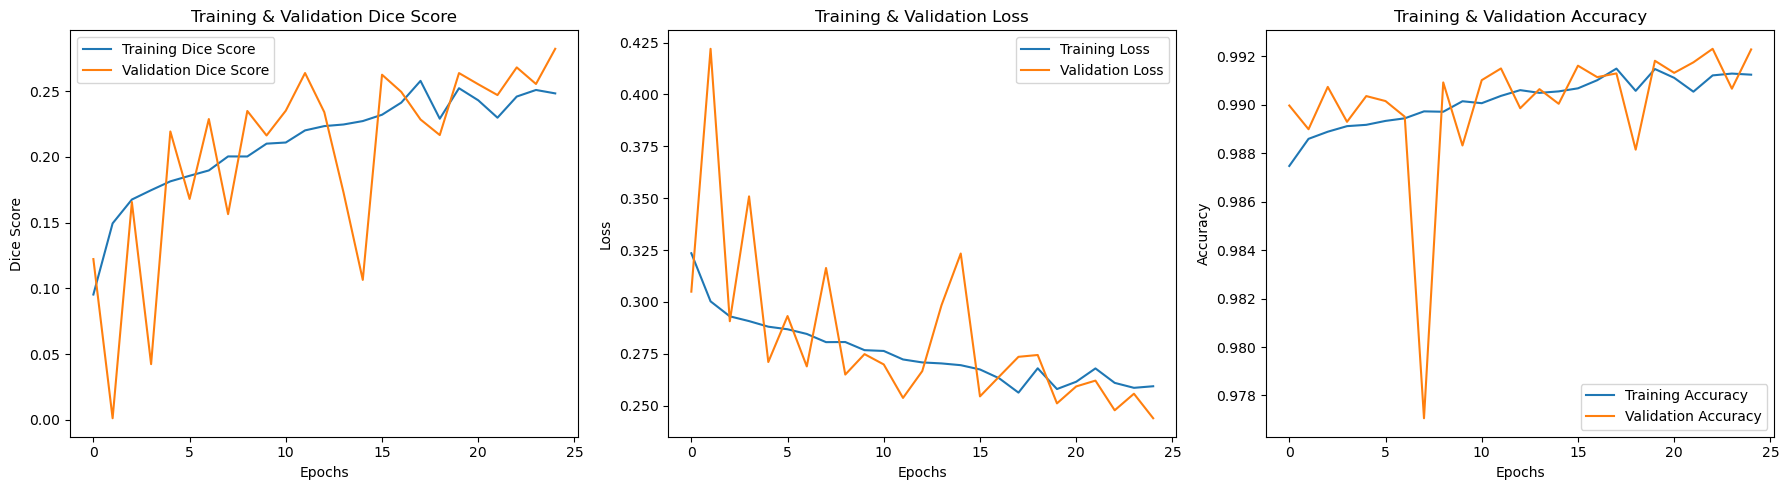

Plotting complete.


In [50]:
import matplotlib.pyplot as plt

def plot_history(history):
    print("Plotting history...")  # Debugging step

    # Extract history dictionary
    history_dict = history  # or history.history depending on how you're calling it

    # Metrics
    dice_mc_metric = history_dict.get('dice_mc_metric', [])
    val_dice_mc_metric = history_dict.get('val_dice_mc_metric', [])
    loss = history_dict.get('loss', [])
    val_loss = history_dict.get('val_loss', [])
    accuracy = history_dict.get('accuracy', [])
    val_accuracy = history_dict.get('val_accuracy', [])

    # Plot the training history
    plt.figure(figsize=(18, 5))

    # Dice Score Plot
    plt.subplot(1, 3, 1)
    plt.plot(dice_mc_metric, label="Training Dice Score")
    plt.plot(val_dice_mc_metric, label="Validation Dice Score")
    plt.xlabel("Epochs")
    plt.ylabel("Dice Score")
    plt.legend()
    plt.title("Training & Validation Dice Score")

    # Loss Plot
    plt.subplot(1, 3, 2)
    plt.plot(loss, label="Training Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training & Validation Loss")

    # Accuracy Plot
    plt.subplot(1, 3, 3)
    plt.plot(accuracy, label="Training Accuracy")
    plt.plot(val_accuracy, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training & Validation Accuracy")

    plt.tight_layout()
    plt.show()

print("Calling plot_history...")
plot_history(unet)
print("Plotting complete.")

#### Prediction process

2025-04-08 00:08:17.556596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [667,256,256,1]
	 [[{{node Placeholder/_1}}]]
2025-04-08 00:08:18.006941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step


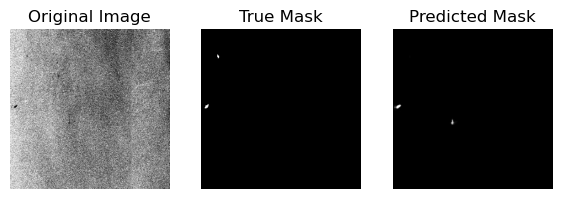

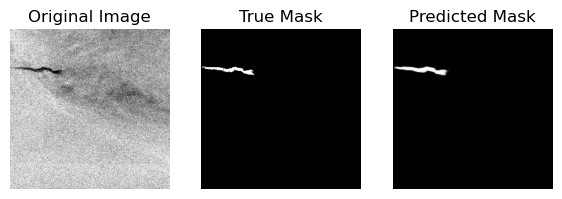

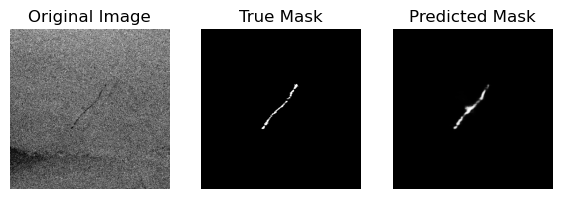

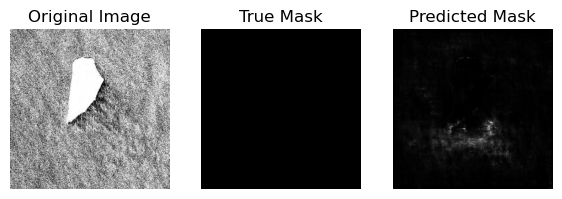

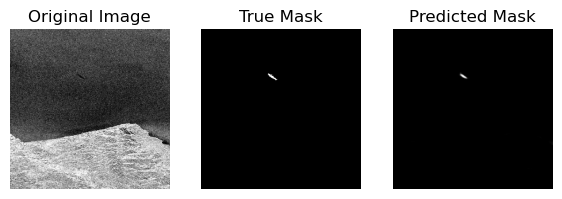

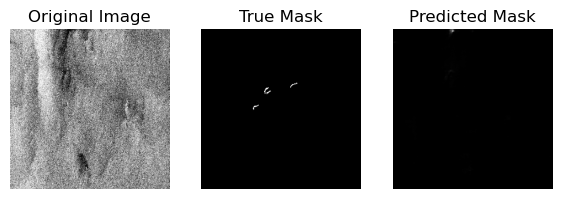

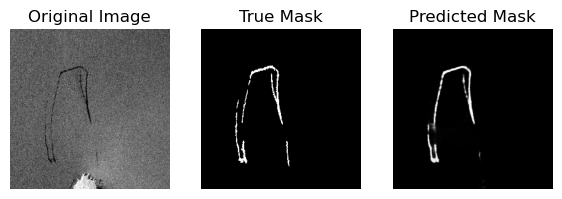

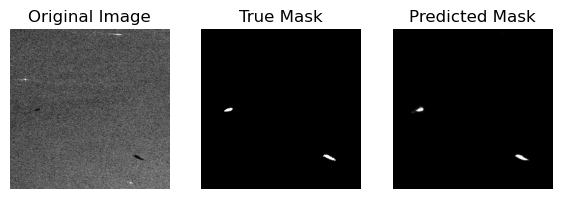

1/1 [==============================] - 0s 72ms/step


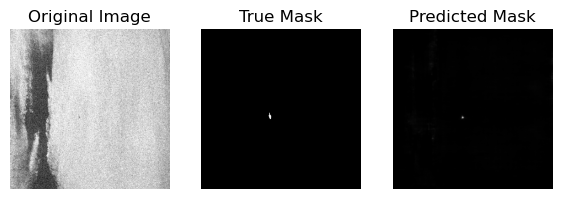

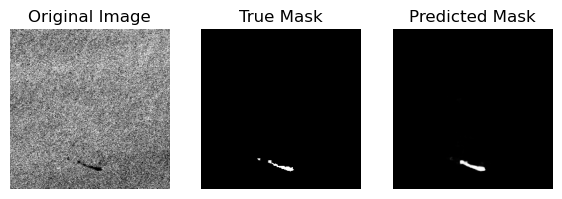

In [53]:
import matplotlib.pyplot as plt

def plot_predict(dataset, model, num_batches=5, total_samples=10):
    count = 0
    for images, masks in dataset.take(num_batches):  # Take more batches to increase variance
        predictions = unet_model.predict(images)
        for i in range(len(images)):
            if count >= total_samples:
                return
            fig, ax = plt.subplots(1, 3, figsize=(7, 5))
            ax[0].imshow(images[i])
            ax[0].set_title("Original Image")
            ax[0].axis('off')
            ax[1].imshow(masks[i, ..., 0], cmap='gray')
            ax[1].set_title("True Mask")
            ax[1].axis('off')
            ax[2].imshow(predictions[i, ..., 0], cmap='gray')
            ax[2].set_title("Predicted Mask")
            ax[2].axis('off')
            plt.show()
            count += 1
            
plot_predict(dataset_test_batched, unet_model, num_batches=5, total_samples=10)

#### Performance Metrics

##### Path creation

In [57]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define directories
test_images_dir = "/Users/sibikarthik/OIL_SPILL_DETECTION/SAR Data/test/images"
test_masks_dir = "/Users/sibikarthik/OIL_SPILL_DETECTION/SAR Data/test/labels"

# Get list of image files
test_image_files = sorted([os.path.join(test_images_dir, f) for f in os.listdir(test_images_dir) if f.endswith('.png') or f.endswith('.jpg')])
test_mask_files = sorted([os.path.join(test_masks_dir, f) for f in os.listdir(test_masks_dir) if f.endswith('.png') or f.endswith('.jpg')])

# Load images and masks into arrays
test_images = np.array([img_to_array(load_img(img_path, target_size=(256, 256))) / 255.0 for img_path in test_image_files])
test_masks = np.array([img_to_array(load_img(mask_path, target_size=(256, 256), color_mode='grayscale')) / 255.0 for mask_path in test_mask_files])

# Reshape masks to match model's expected output
test_masks = test_masks.squeeze()  # Remove extra channel if necessary

print(f"Loaded {len(test_images)} test images.")
print(f"Loaded {len(test_masks)} test masks.")

Loaded 110 test images.
Loaded 110 test masks.


##### Confusion matrix, Precision, Recall, and F1 score

4/4 [==============================] - 6s 1s/step
Test Masks Shape: (110, 256, 256)
Prediction Shape: (110, 256, 256, 1)

True Negatives (TN): 7112722
False Positives (FP): 19132
False Negatives (FN): 20042
True Positives (TP): 57064



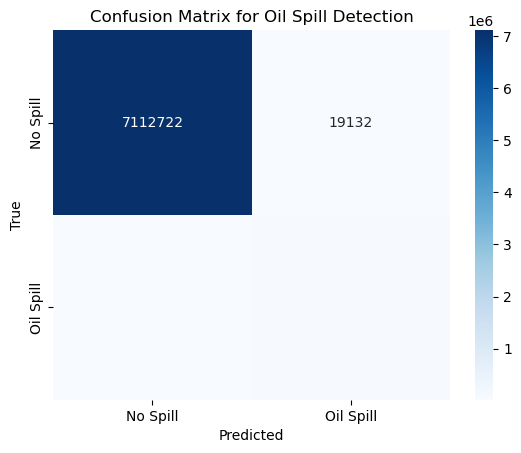

Precision: 0.7489
Recall: 0.7401
F1 Score: 0.7445


In [284]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import cv2

# Generate predictions
prediction = unet_model.predict(test_images)

# Print shapes to verify alignment
print(f"Test Masks Shape: {test_masks.shape}")
print(f"Prediction Shape: {prediction.shape}")

binary_predictions = []
for i in range(prediction.shape[0]):
    pred_mask = prediction[i, :, :, 0]  # shape is (batch, height, width, 1)
    pred_mask_scaled = (pred_mask * 255).astype(np.uint8)  # scale to 0-255
    _, binary_mask = cv2.threshold(pred_mask_scaled, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary_predictions.append((binary_mask / 255).astype(np.uint8))

# Stack to get a numpy array of shape (batch, height, width)
binary_predictions = np.array(binary_predictions)

# Flatten arrays for evaluation
unet_true_labels = (test_masks.flatten() > 0.5).astype(np.uint8)
unet_predicted_labels = binary_predictions.flatten().astype(np.uint8)

# Compute confusion matrix
cm = confusion_matrix(unet_true_labels, unet_predicted_labels)

# Print confusion matrix values for verification
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}\n")

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Spill', 'Oil Spill'], yticklabels=['No Spill', 'Oil Spill'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Oil Spill Detection')
plt.show()

# Compute precision, recall, and F1-score
precision = precision_score(unet_true_labels, unet_predicted_labels, average='binary', zero_division=1)
recall = recall_score(unet_true_labels, unet_predicted_labels, average='binary', zero_division=1)
f1 = f1_score(unet_true_labels, unet_predicted_labels, average='binary', zero_division=1)

# Display metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

#####

#### Intensity Calculation

##### Loading and Preprocessing of the image

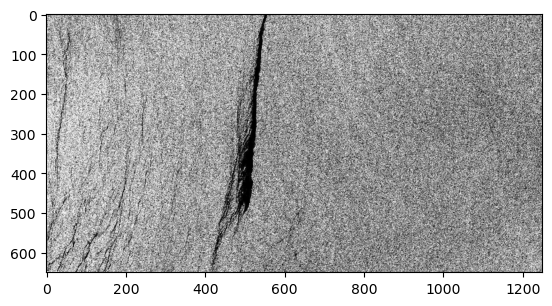

In [14]:
def load_image(image_path, resize=True, img_size=(256, 256)):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Image at {image_path} not found or cannot be read.")
    original_image = image.copy()
    
    # Resize only if needed for model input
    if resize:
        image = cv2.resize(image, img_size)
    image = image.astype(np.float32) / 255.0  # Normalize
    return original_image, image  # Return both original and resized images

image_path = "/Users/sibikarthik/OIL_SPILL_DETECTION/SAR Data/test/images/img_0105.jpg"
original_image, model_input = load_image(image_path, resize=True)
original_image = original_image.astype(np.float32) / 255.0

plt.imshow(original_image, cmap='gray')

##### Checking image dimensions

In [965]:
print("Original Image Shape:", original_image.shape)
print("Resized Model Input Shape:", model_input.shape)
print("Model Input Expected Shape:", unet_model.input_shape)

Original Image Shape: (650, 1250)
Resized Model Input Shape: (256, 256)
Model Input Expected Shape: (None, 256, 256, 3)


##### Defining Dice Coefficient metric

In [16]:
import tensorflow.keras.backend as K

def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-6)

##### Compiling model with metrics

In [971]:
from tensorflow.keras.metrics import MeanIoU

unet_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', MeanIoU(num_classes=2), dice_coefficient])

##### Prediction and processing using Otsu thresholding

In [19]:
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import MeanIoU
import cv2
import numpy as np

original_image, model_input = load_image(image_path)

# Ensuring grayscale image matches model's 3-channel input
model_input = np.stack([model_input] * 3, axis=-1)
model_input = np.expand_dims(model_input, axis=0)

# Getting the predicted mask
pred_mask = unet_model.predict(model_input)[0, :, :, 0]
cv2.imwrite("mask_output_1.png", pred_mask * 255)  # scale to 0-255 for visualization

# Convert predicted mask to 8-bit grayscale (0-255)
pred_mask_8bit = (pred_mask * 255).astype(np.uint8)

# Apply Otsu's thresholding
_, binary_mask_otsu = cv2.threshold(pred_mask_8bit, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Resize binary mask to match original image shape
binary_mask = cv2.resize(binary_mask_otsu, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)

# Optionally convert to 0/1 format for further metric calculations
binary_mask = (binary_mask / 255).astype(np.uint8)

1/1 [==============================] - 1s 651ms/step


##### To decide on threshold

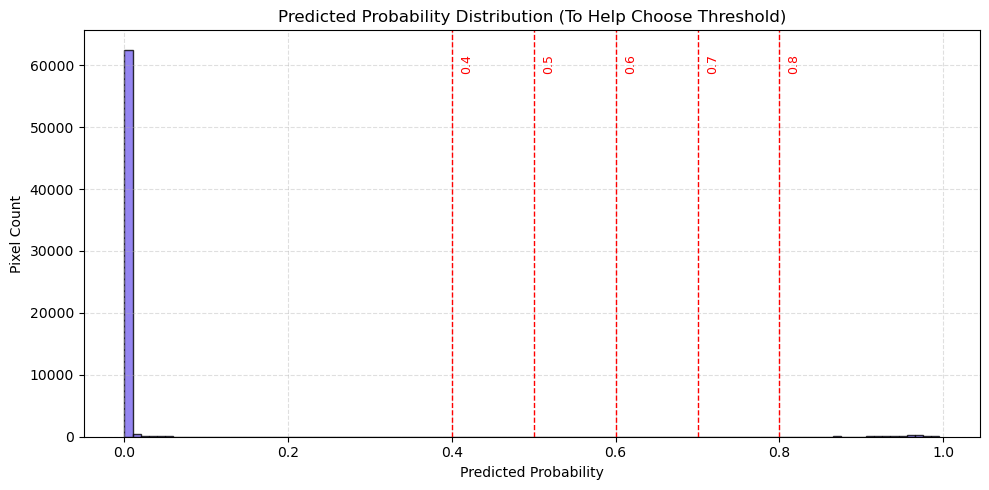

In [976]:
import matplotlib.pyplot as plt
import numpy as np

flat_preds = pred_mask.flatten()

plt.figure(figsize=(10, 5))
plt.hist(flat_preds, bins=100, color='mediumslateblue', edgecolor='black', alpha=0.8)

thresholds = [0.4, 0.5, 0.6, 0.7, 0.8]
for t in thresholds:
    plt.axvline(x=t, color='red', linestyle='--', linewidth=1)
    plt.text(t + 0.01, plt.ylim()[1]*0.9, f'{t}', rotation=90, color='red', fontsize=9)

plt.title("Predicted Probability Distribution (To Help Choose Threshold)")
plt.xlabel("Predicted Probability")
plt.ylabel("Pixel Count")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [21]:
print("Predicted Mask Shape: ", pred_mask.shape)
print("Binary Mask Shape:", binary_mask.shape)

Predicted Mask Shape:  (256, 256)
Binary Mask Shape: (650, 1250)


##### Masks

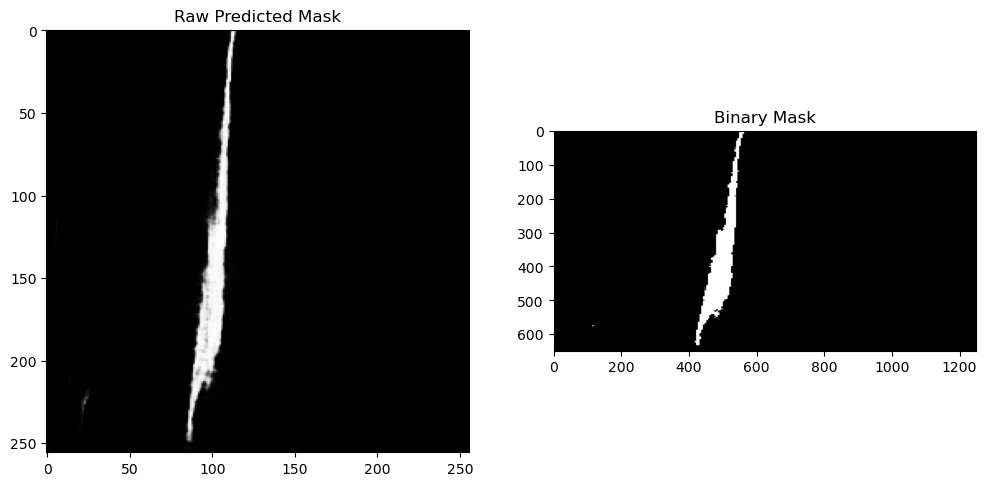

In [24]:
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.title("Raw Predicted Mask")
plt.imshow(pred_mask, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Binary Mask")
plt.imshow(binary_mask, cmap='gray')

plt.show()

##### Resizing function for shape equality

In [27]:
from skimage.transform import resize

def resize_mask(mask, target_shape):
    if mask.shape != target_shape:
        return resize(mask, target_shape, mode='constant', preserve_range=True)
    return mask

##### Intersection and union pixels

In [30]:
pred_mask = resize_mask(pred_mask, binary_mask.shape)

intersection = np.logical_and(pred_mask, binary_mask).sum()
union = np.logical_or(pred_mask, binary_mask).sum()

print(f"Intersection Pixels: {intersection:.2f}\nUnion Pixels: {union:.2f}")

Intersection Pixels: 22497.00
Union Pixels: 812500.00


##### Extracting oil spill pixels and analyzing intensity

In [33]:
from skimage.transform import resize
binary_mask = resize(binary_mask, original_image.shape[:2], anti_aliasing=True)
spill_pixels = original_image[binary_mask == 1]

##### Calculating density metrics

In [36]:
spill_pixels = original_image[binary_mask > 0]

mean_intensity = np.mean(spill_pixels) if spill_pixels.size > 0 else 0
std_dev = np.std(spill_pixels) if spill_pixels.size > 0 else 0

print(f"Mean Intensity: {mean_intensity:.2f}\nStandard Deviation: {std_dev:.2f}")

Mean Intensity: 67.92
Standard Deviation: 73.04


##### Shape dimensions

In [990]:
print(original_image.shape)
print(pred_mask.shape)
print(binary_mask.shape)

(650, 1250)
(650, 1250)
(650, 1250)


##### Adaptive Thresholding

In [40]:
low_threshold, high_threshold = 70, 150

def classify_density(pixel):
    if pixel >= high_threshold:
        return 2  # High Density
    elif pixel >= low_threshold:
        return 1  # Medium Density
    else:
        return 0  # Low Density

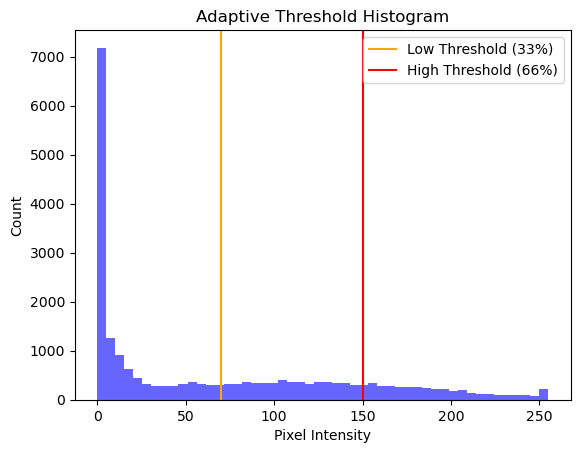

In [997]:
plt.hist(spill_pixels, bins=50, color='blue', alpha=0.6)
plt.axvline(low_threshold, color='orange', label='Low Threshold (33%)')
plt.axvline(high_threshold, color='red', label='High Threshold (66%)')
plt.title("Adaptive Threshold Histogram")
plt.xlabel("Pixel Intensity")
plt.ylabel("Count")
plt.legend()
plt.show()

##### Density map creation

In [42]:
density_map = np.vectorize(classify_density)(original_image) * binary_mask

##### Visualizing the density map

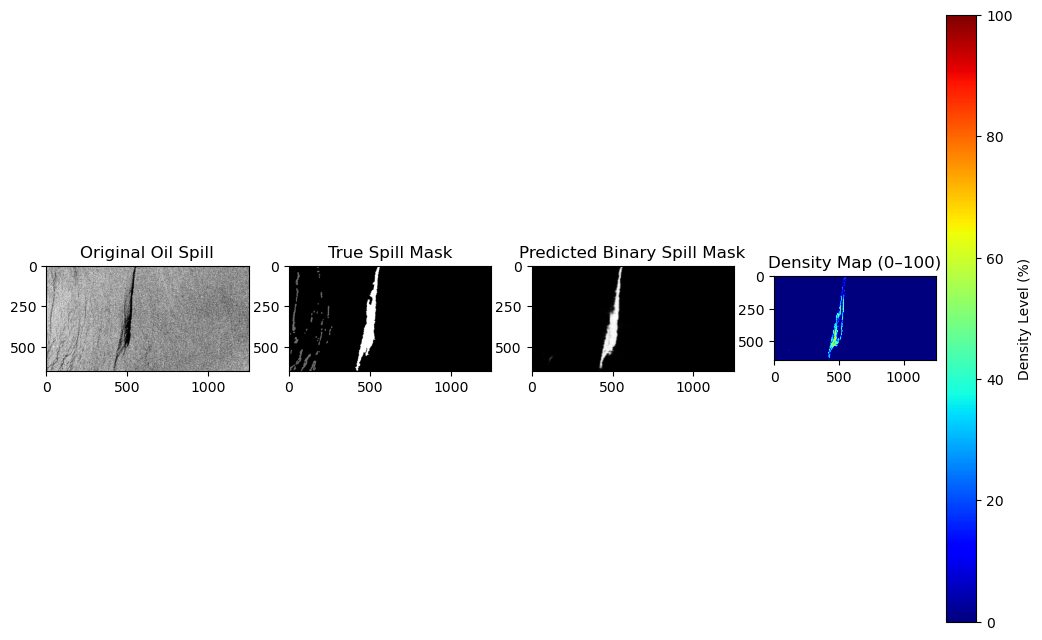

Mean Intensity: 67.92, Standard Deviation: 73.04


In [44]:
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Normalize the density map to range from 0 to 100
normed_density = 100 * (density_map - np.min(density_map)) / (np.max(density_map) - np.min(density_map))

plt.figure(figsize=(12, 8))

plt.subplot(1, 4, 1)
plt.title("Original Oil Spill")
plt.imshow(original_image, cmap='gray')

# Adjust label path as required
label_path = image_path[:53] + "labels/" + image_path[60:69] + "png"
original_label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

plt.subplot(1, 4, 2)
plt.title("True Spill Mask")
plt.imshow(original_label, cmap='gray')

plt.subplot(1, 4, 3)
plt.title("Predicted Binary Spill Mask")
plt.imshow(pred_mask, cmap='gray')

plt.subplot(1, 4, 4)
plt.title("Density Map (0–100)")
img = plt.imshow(normed_density, cmap='jet', vmin=0, vmax=100)
cbar = plt.colorbar(img)
cbar.set_label('Density Level (%)')
cbar.set_ticks([0, 20, 40, 60, 80, 100])

plt.show()

# Print Density Metrics (for the original map, not scaled one)
print(f"Mean Intensity: {mean_intensity:.2f}, Standard Deviation: {std_dev:.2f}")

##### Final output of performance metrics

In [46]:
# Binarize masks if not already
binary_mask = (binary_mask > 0).astype(np.uint8)
pred_mask = (pred_mask > 0).astype(np.uint8)

# Compute Intersection and Union
intersection = np.sum(binary_mask & pred_mask)
union = np.sum(binary_mask | pred_mask)

# Compute Dice Coefficient
accuracy = dice_coefficient(binary_mask, pred_mask)

# Compute IoU
iou = intersection / (union + 1e-6)

# Spill Area
spill_area = np.sum(binary_mask)

# Precision and Recall
true_positive = intersection
false_positive = np.sum(pred_mask) - true_positive
false_negative = np.sum(binary_mask) - true_positive

precision = true_positive / (true_positive + false_positive + 1e-6)
recall = true_positive / (true_positive + false_negative + 1e-6)

# Print Metrics
print(f"Accuracy (Dice Coefficient): {accuracy:.4f}")
print(f"Intersection over Union (IoU): {iou:.4f}")
print(f"Spill Area (Total Spill Pixels): {spill_area}")
print(f"Mean Intensity: {mean_intensity:.2f}")
print(f"Standard Deviation: {std_dev:.2f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy (Dice Coefficient): 0.0539
Intersection over Union (IoU): 0.0277
Spill Area (Total Spill Pixels): 22497
Mean Intensity: 67.92
Standard Deviation: 73.04
Precision: 0.0277
Recall: 1.0000
